In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))


%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis


In [2]:
from otgnn.models import GCN
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer

from rdkit.Chem import MolFromSmiles

import torch
import numpy as np
import time

In [3]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

In [163]:
model = "transformer1"
model_iter = 65 

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

(MolOpt(
   (GCN): GCN(
     (W_message_i): Linear(in_features=100, out_features=50, bias=False)
     (W_message_h): Linear(in_features=50, out_features=50, bias=False)
     (W_message_o): Linear(in_features=143, out_features=50, bias=True)
     (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
     (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
     (dropout_gcn): Dropout(p=0.0, inplace=False)
     (dropout_ffn): Dropout(p=0.0, inplace=False)
   )
   (opt0): Linear(in_features=50, out_features=50, bias=True)
   (opt1): Linear(in_features=50, out_features=50, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer1_decode', init_model='transformer1', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_

In [164]:
molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

(MolOptDecoder(
   (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
   (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
   (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
   (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
   (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
   (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', batch_norm=False, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, ffn_activation='LeakyReLU', init_decoder_model='transformer1_decode', init_model='transformer1', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', output_dir='mol_opt/output', pc_hidden=50, penalty_lambda=0.015, pred_hidden=150, sinkhorn_entropy=0.1, sinkhorn_max_it=10000))

In [165]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 96, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)

In [166]:
for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

# Assess GCN

In [167]:
x_embedding, x_delta_hat = molopt.forward(X)
y_embedding = molopt.encode(Y)

In [168]:
x_embedding + x_delta_hat

tensor([[ 53.9534,  18.0619, 127.9203,  ..., 205.4508, -13.7877, 117.6844],
        [  2.6774,   4.3066,  79.5204,  ..., 133.3041,  17.3828,  41.0220],
        [ 19.5625, -13.5629,  46.0779,  ...,  70.5231,  18.2179,  24.8748],
        ...,
        [ 35.6772,  -8.8476,  94.7022,  ..., 180.1953,  -7.6483,  86.9991],
        [  6.1454,  25.7984,  97.7587,  ..., 134.9748,   1.2747,  57.2661],
        [ 30.6252,  27.5654, 138.7552,  ..., 164.7148, -17.5071, 104.5643]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [169]:
y_embedding

tensor([[ 0.1893,  0.5531, -0.6160,  ..., -0.0014, -0.2123,  1.0153],
        [ 0.0498,  0.2393, -0.1993,  ..., -0.2156,  0.0070,  0.2408],
        [ 0.0658,  0.0238, -0.0965,  ...,  0.0728,  0.1410,  0.0544],
        ...,
        [-0.0669,  0.3518,  0.0351,  ..., -0.1768, -0.0394,  0.4411],
        [-0.0116,  0.1551, -0.3137,  ...,  0.0035,  0.0091,  0.3334],
        [-0.1221, -0.0518,  0.0064,  ..., -0.1541,  0.0265,  0.2411]],
       device='cuda:0', grad_fn=<CopySlices>)

In [170]:
x_embedding

tensor([[ 1.8826e-01,  5.5727e-01, -5.5762e-01,  ..., -4.1595e-02,
         -2.2809e-01,  1.1088e+00],
        [ 4.9842e-02,  2.3928e-01, -1.9931e-01,  ..., -2.1558e-01,
          7.0240e-03,  2.4079e-01],
        [ 5.1531e-02,  2.1008e-02, -2.0051e-01,  ...,  1.1533e-01,
          1.5456e-01,  5.0281e-01],
        ...,
        [ 4.1171e-02,  2.1649e-01, -2.9196e-01,  ..., -1.8443e-01,
          2.7536e-01,  3.4300e-01],
        [-6.7063e-03,  1.3980e-01, -4.0490e-01,  ...,  3.2670e-02,
          4.9516e-02,  4.7165e-01],
        [-5.7216e-02, -1.1143e-01, -9.4287e-04,  ...,  1.7797e-02,
         -5.7628e-02,  1.6475e-01]], device='cuda:0', grad_fn=<CopySlices>)

In [171]:
x_delta_hat

tensor([[ 53.7651,  17.5047, 128.4780,  ..., 205.4924, -13.5596, 116.5756],
        [  2.6276,   4.0674,  79.7197,  ..., 133.5197,  17.3758,  40.7812],
        [ 19.5109, -13.5839,  46.2784,  ...,  70.4078,  18.0634,  24.3720],
        ...,
        [ 35.6360,  -9.0641,  94.9942,  ..., 180.3797,  -7.9236,  86.6562],
        [  6.1521,  25.6586,  98.1636,  ..., 134.9421,   1.2251,  56.7944],
        [ 30.6825,  27.6768, 138.7562,  ..., 164.6970, -17.4495, 104.3995]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# Run all model, get some predictions

In [172]:
for idx, i in enumerate(val_data_loader):
    if idx == 1:
        X = (MolGraph(i[0]))
        Y = (MolGraph(i[1]))
        break

In [173]:
x_embedding, x_delta_hat = molopt.forward(X)
results_logits = molopt_decoder.forward(x_embedding + x_delta_hat, Y)
results_labels = molopt_decoder.discretize(*results_logits)

In [174]:
symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

In [175]:
symbols_labels

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', grad_fn=<NotImplemented>)

In [176]:
bonds_labels_arr = bonds_labels.cpu().numpy()

In [177]:
np.unique(bonds_labels_arr, return_counts=True)

(array([0, 1, 4]), array([ 1686,    34, 41894]))

In [178]:
target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [179]:
print (np.unique(target_symbols_labels.cpu().numpy(), return_counts=True))
print (np.unique(symbols_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 7, 8]), array([1528,  207,  198,   34,   44,   23,    4]))
(array([0, 1, 2, 3, 4, 7]), array([1825,   66,   91,   38,   11,    7]))


In [180]:
print (np.unique(target_bonds_labels.cpu().numpy(), return_counts=True))
print (np.unique(bonds_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 4]), array([ 3170,  1178,     6, 39260]))
(array([0, 1, 4]), array([ 1686,    34, 41894]))


In [181]:
bonds_logits.shape

torch.Size([43614, 5])

In [182]:
lex = Y.scope[0][1]
bonds_logits.narrow(0,0,lex ** 2).view(lex, lex, 5)[:,:,0]

tensor([[-4.5941, -1.2853,  0.6672, -1.0132, -3.0848, -1.0582, -0.9596, -1.2877,
         -2.0035, -0.3495, -1.5174, -1.2257, -0.5620, -3.0364, -1.8199, -3.2407,
         -1.9931, -0.9880, -0.6924, -1.8818, -2.0132,  1.2430],
        [-1.2853,  0.5235,  2.2392,  1.3015, -0.7791,  1.4125,  1.1578,  0.9372,
         -0.3207,  2.7516,  1.3966,  0.9763,  1.6980, -1.0303,  0.0609, -0.2833,
          0.1017,  1.6357,  1.3332,  0.5854,  0.5896,  2.6972],
        [ 0.6672,  2.2392,  4.4545,  2.3505,  1.4543,  2.1004,  1.9668,  2.6005,
          1.0261,  3.9692,  2.7440,  2.7979,  2.5297,  0.3715,  1.3016,  1.9131,
          1.9740,  2.9355,  2.2299,  1.3560,  2.9308,  4.0239],
        [-1.0132,  1.3015,  2.3505, -1.5322, -0.4740, -1.7676, -1.9144,  0.3444,
         -0.0493, -0.2057, -0.0849, -1.3990, -1.5436, -1.1994, -0.2244, -0.7022,
          0.1230, -0.9142, -2.1428, -0.2162, -0.4140,  2.1123],
        [-3.0848, -0.7791,  1.4543, -0.4740, -2.7137, -0.9476, -1.0215, -0.8737,
         -0.717

In [183]:
symbols_labels

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', grad_fn=<NotImplemented>)

In [184]:
os.getcwd()

'/home/octav/gitrepos/tum-thesis'

# Visualize

In [185]:
from tensorboardX import SummaryWriter
tb_writer = SummaryWriter(logdir = "mol_opt/logs")

mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)

In [186]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

In [187]:
symbols_labels.shape

torch.Size([2038])

In [139]:
sum([y for _, y in Y.scope])

2038

In [ ]:
mol_drawer.visualize_batch(prediction, target_smiles, 8, initial_smiles)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [33]:
bond_idx = 1
for idx, (stx, lex) in enumerate(Y.scope):
    dev_sym = prediction[0][0].narrow(0, stx, lex).cpu().numpy()
    np.savetxt('symbols.txt', dev_sym, fmt='%i')
    np.savetxt('charges.txt', prediction[0][1].narrow(0, stx, lex).cpu().numpy(), fmt='%i')
    
    dev_bnd = prediction[0][2].narrow(0, bond_idx, lex*lex).view(lex, lex).cpu().numpy()
    np.savetxt('bonds.txt', dev_bnd, fmt='%i')
    bond_idx += lex * lex
    
    if idx == 0:
        break

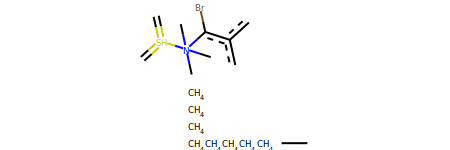

In [32]:
smiles = "C.C.C.C.C.C.C.C=S(=C)(=C)N(C)(C)(C)c(Br)c(c)c.CC"
smiles = "C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC"
from rdkit import Chem

from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smiles, sanitize = False)

In [43]:
# Chem.MolFromSmiles("C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC")

In [379]:
smiles

'C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC'

In [380]:
bonds_labels

tensor([4, 4, 4,  ..., 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [381]:
dev_sym

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0])

In [38]:
mol = feat2smiles(SYMBOLS,None,BOND_TYPES,dev_sym, None, dev_bnd)

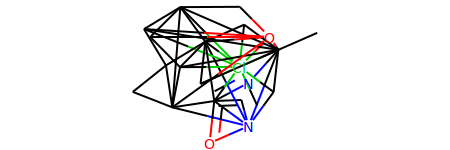

In [39]:
mol

In [35]:
for atom in mol.GetAtoms():
    print (atom.GetSymbol(), atom.GetFormalCharge(), atom.GetIsAromatic())

AttributeError: 'str' object has no attribute 'GetAtoms'

In [384]:
Chem.MolToSmiles(mol)

'C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.C.CC.CN.O.O'

In [341]:
Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

'C.CCl'

In [342]:
Chem.MolFromSmiles(Chem.MolToSmiles(mol), sanitize = False)